# Can fingerprint distances discriminate DFG conformations?

The `kissim` fingerprint encodes the pocket residues' spatial distance to four centers&mdash;the pocket centroid, hinge region, DFG region and front pocket&mdash;and should therefore discriminate between two structures in different conformations; when we compare two structures in *different* conformations the fingerprint distance should be higher than for two structures in *similar* conformations.

Let's check if this is true using DFG conformations from KLIFS. Plot distribution of fingerprint distances grouped by in/in, out/out, and in/out pairs.

- Use fingerprint distances for structure pairs between all kinases
- Use fingerprint distances for structure pairs between the same kinase

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from opencadd.databases.klifs import setup_remote
from kissim.comparison import FingerprintDistanceGenerator

from src.definitions import COVERAGE_CUTOFF

In [3]:
HERE = Path(_dh[-1])  # noqa: F821
DATA = HERE / "../../results/"

In [4]:
plt.style.use("seaborn")

## Load fingerprint distances with sufficient coverage

Choose fingerprint distances that are based on spatial distances only (**weighting scheme: 010**) and that are based on a sufficient pairwise fingerprint bit coverage (default: `COVERAGE_CUTOFF`).

In [5]:
COVERAGE_CUTOFF

0.8

In [6]:
# Set path
fingerprint_distance_file = DATA / "fingerprint_distances_010.csv"
# Load data
fingerprint_distance_generator = FingerprintDistanceGenerator.from_csv(fingerprint_distance_file)
print(f"Number of kinases: {len(fingerprint_distance_generator.kinase_ids)}")
print(f"Number of structures: {len(fingerprint_distance_generator.structure_ids)}")
structure_distances = fingerprint_distance_generator.data
print(f"Number of structure pairs: {structure_distances.shape[0]}")
structure_distances = structure_distances[
    structure_distances["bit_coverage"] >= COVERAGE_CUTOFF
].reset_index(drop=True)
print(f"Number of structure pairs: {structure_distances.shape[0]}")
structure_distances.head()

Number of kinases: 292
Number of structures: 5222
Number of structure pairs: 13632031
Number of structure pairs: 13236869


,structure.1,structure.2,kinase.1,kinase.2,distance,bit_coverage
0,3833,6679,AAK1,AAK1,0.053907,1.0
1,3833,7156,AAK1,AAK1,0.065987,1.0
2,3833,1086,AAK1,ABL1,0.140360,1.0
3,3833,1054,AAK1,ABL1,0.149352,1.0
4,3833,1090,AAK1,ABL1,0.126901,1.0


## Add DFG conformation

Add DFG conformation from KLIFS to each structure pair.

In [7]:
%%time
klifs_session = setup_remote()
structures = klifs_session.structures.all_structures()
dfg = structures.set_index("structure.klifs_id")["structure.dfg"]
structure_distances["dfg.1"] = structure_distances["structure.1"].apply(lambda x: dfg[x])
structure_distances["dfg.2"] = structure_distances["structure.2"].apply(lambda x: dfg[x])
structure_distances.head()

CPU times: user 1min 24s, sys: 435 ms, total: 1min 24s
Wall time: 1min 27s


,structure.1,structure.2,kinase.1,kinase.2,distance,bit_coverage,dfg.1,dfg.2
0,3833,6679,AAK1,AAK1,0.053907,1.0,in,in
1,3833,7156,AAK1,AAK1,0.065987,1.0,in,in
2,3833,1086,AAK1,ABL1,0.140360,1.0,in,out-like
3,3833,1054,AAK1,ABL1,0.149352,1.0,in,out
4,3833,1090,AAK1,ABL1,0.126901,1.0,in,in


## Plot DFG conformation pairs

Group the structure pairs by DFG conformation pairs&mdash;in/in, out/out, in/out&mdash;and plot their fingerprint distance distributions.

In [8]:
def structure_distances_by_dfg_conformation_pairs(structure_distances):
    """Distances for all, in/in, out/out, and in/out structure pairs."""

    dfg_all = structure_distances["distance"]
    dfg_in_in = structure_distances[
        (structure_distances["dfg.1"] == "in") & (structure_distances["dfg.2"] == "in")
    ]["distance"]
    dfg_out_out = structure_distances[
        (structure_distances["dfg.1"] == "out") & (structure_distances["dfg.2"] == "out")
    ]["distance"]
    dfg_in_out = structure_distances[
        ((structure_distances["dfg.1"] == "in") & (structure_distances["dfg.2"] == "out"))
        | ((structure_distances["dfg.1"] == "out") & (structure_distances["dfg.2"] == "in"))
    ]["distance"]

    structure_distances_dfg = pd.DataFrame(
        {"all": dfg_all, "in/in": dfg_in_in, "out/out": dfg_out_out, "in/out": dfg_in_out}
    )
    structure_distances_dfg = pd.DataFrame(structure_distances_dfg)

    return structure_distances_dfg

In [9]:
def plot_structure_distances_by_dfg_conformation_pairs(structure_distances):
    """Plot distribution of structure distances per DFG conformation pair."""

    # Data
    structure_distances_dfg = structure_distances_by_dfg_conformation_pairs(structure_distances)
    print("Number of structure pairs per conformation pair:")
    print(structure_distances_dfg.notna().sum())

    # Boxplot
    structure_distances_dfg.plot(
        kind="box", title="Conformation dependent structure pair distances"
    )
    plt.show()

    # Stats
    display(structure_distances_dfg.describe())

### All structures

Use fingerprint distances for structure pairs between all kinases.

Number of structure pairs per conformation pair:
all        13236869
in/in       9889372
out/out      103124
in/out      2023285
dtype: int64


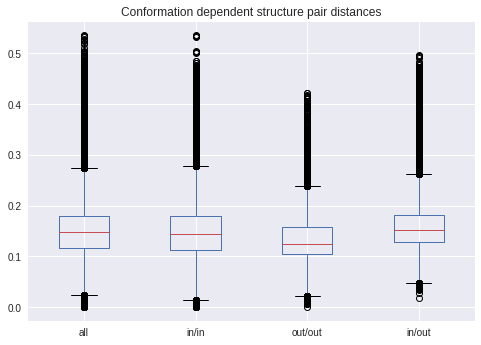

,all,in/in,out/out,in/out
count,1.323687e+07,9.889372e+06,103124.000000,2.023285e+06
mean,1.523262e-01,1.495868e-01,0.136420,1.604700e-01
std,5.115911e-02,5.164462e-02,0.054687,4.748242e-02
min,0.000000e+00,0.000000e+00,0.000000,1.784707e-02
25%,1.171413e-01,1.129086e-01,0.104026,1.280362e-01
50%,1.471836e-01,1.451464e-01,0.124712,1.519613e-01
75%,1.798548e-01,1.787767e-01,0.158204,1.820236e-01
max,5.353785e-01,5.353785e-01,0.422093,4.958527e-01


In [10]:
plot_structure_distances_by_dfg_conformation_pairs(structure_distances)

<div class="alert alert-block alert-info">

When including all kinases at the same time, the distribution of fingerprint distances is similar for structure pairs with the same DFG conformations (in/in and out/out) and different DFG conformations (in/out). 
    
The fingerprint seems not to discriminate DFG-conformations on a kinome-wide level, maybe because the encoded spatial information is not restricted to only DFG conformation features. We may see a disciminative effect when comparing structures for a single kinase.

</div>

### Structures for one kinase

Use fingerprint distances for structure pairs between the same kinase; use only kinases that have a sufficient number of structures in DFG-in and DFG-out conformations (default: 10). 

In [11]:
def kinases_with_high_dfg_in_out_coverage(structure_distances, dfg_structure_coverage_cutoff=10):
    """Given a dataset, get kinases with a threshold DFG in/out coverage."""

    # Get structure KLIFS IDs in our dataset
    structure_klifs_ids = (
        pd.concat(
            [
                structure_distances["structure.1"].drop_duplicates(),
                structure_distances["structure.2"].drop_duplicates(),
            ]
        )
        .drop_duplicates()
        .to_list()
    )
    print(f"Number of structures: {len(structure_klifs_ids)}")

    # Get structural metadata
    klifs_session = setup_remote()
    structures = klifs_session.structures.all_structures()
    structures = structures[structures["structure.klifs_id"].isin(structure_klifs_ids)]

    # Count number of structures per kinase and conformation
    dfg_by_kinase = structures.groupby("kinase.klifs_name").apply(
        lambda x: x["structure.dfg"].value_counts()
    )
    dfg_by_kinase = dfg_by_kinase.reset_index()
    dfg_by_kinase.columns = ["kinase", "dfg", "n_structures"]

    # Keep only in/out rows
    dfg_by_kinase = dfg_by_kinase[(dfg_by_kinase["dfg"] == "in") | (dfg_by_kinase["dfg"] == "out")]

    # Keep only rows with at least xxx structures
    dfg_by_kinase = dfg_by_kinase[dfg_by_kinase["n_structures"] >= dfg_structure_coverage_cutoff]

    # Keep only kinases with both in/out conformations
    n_conformations_by_kinase = dfg_by_kinase.groupby("kinase").size()
    dfg_by_kinase = dfg_by_kinase[
        dfg_by_kinase["kinase"].isin(
            n_conformations_by_kinase[n_conformations_by_kinase == 2].index
        )
    ]

    return dfg_by_kinase.set_index(["kinase", "dfg"])

In [12]:
dfg_by_kinase = kinases_with_high_dfg_in_out_coverage(
    structure_distances, dfg_structure_coverage_cutoff=10
)
dfg_by_kinase

Number of structures: 5147


n_structures
kinase dfg              
BRAF   in             59
       out            33
CDK8   in             21
       out            10
EphA2  in             39
       out            17
MET    in             54
       out            16
p38a   in            127
       out            73

#### BRAF

Number of DFG-in structures: 59
Number of DFG-out structures: 33
Percentage of DFG-in: 64.13%
Number of structure pairs per conformation pair:
all        4186
in/in      1711
out/out     528
in/out     1947
dtype: int64


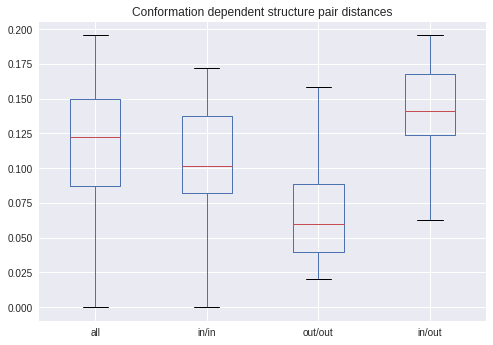

,all,in/in,out/out,in/out
count,4186.000000,1711.000000,528.000000,1947.000000
mean,0.115217,0.100434,0.066160,0.141511
std,0.044041,0.041935,0.030018,0.029071
min,0.000000,0.000000,0.020245,0.062493
25%,0.087432,0.082326,0.039570,0.123676
50%,0.122221,0.101930,0.060000,0.140936
75%,0.149824,0.137323,0.088355,0.167770
max,0.195575,0.171852,0.158807,0.195575


#### CDK8

Number of DFG-in structures: 21
Number of DFG-out structures: 10
Percentage of DFG-in: 67.74%
Number of structure pairs per conformation pair:
all        465
in/in      210
out/out     45
in/out     210
dtype: int64


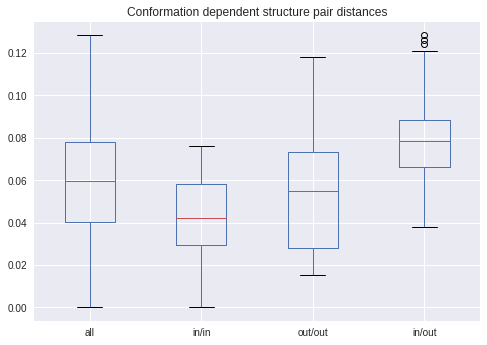

,all,in/in,out/out,in/out
count,465.000000,210.000000,45.000000,210.000000
mean,0.060389,0.043474,0.055098,0.078438
std,0.025646,0.016153,0.029844,0.019773
min,0.000000,0.000000,0.015340,0.037885
25%,0.040096,0.029215,0.028138,0.066106
50%,0.059706,0.042049,0.054649,0.078363
75%,0.078025,0.058398,0.073398,0.088176
max,0.128357,0.076345,0.118087,0.128357


#### EphA2

Number of DFG-in structures: 39
Number of DFG-out structures: 17
Percentage of DFG-in: 69.64%
Number of structure pairs per conformation pair:
all        1540
in/in       741
out/out     136
in/out      663
dtype: int64


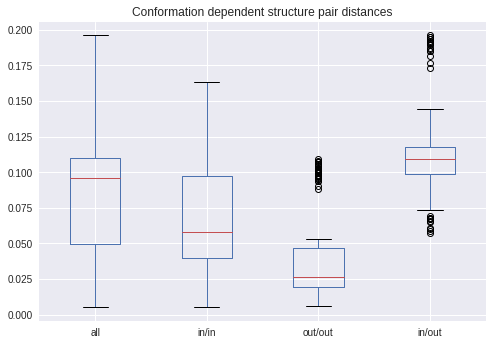

,all,in/in,out/out,in/out
count,1540.000000,741.000000,136.000000,663.000000
mean,0.083082,0.066447,0.042226,0.110054
std,0.038612,0.036639,0.032650,0.019149
min,0.005165,0.005165,0.006354,0.057455
25%,0.049248,0.039641,0.019124,0.099028
50%,0.095837,0.058000,0.026719,0.109181
75%,0.109741,0.097042,0.046460,0.117977
max,0.196033,0.163264,0.109037,0.196033


#### MET

Number of DFG-in structures: 54
Number of DFG-out structures: 16
Percentage of DFG-in: 77.14%
Number of structure pairs per conformation pair:
all        2556
in/in      1431
out/out     120
in/out      864
dtype: int64


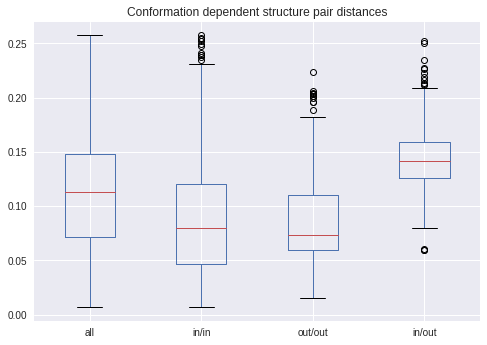

,all,in/in,out/out,in/out
count,2556.000000,1431.000000,120.000000,864.000000
mean,0.110627,0.092511,0.092190,0.143637
std,0.050592,0.052888,0.051869,0.026834
min,0.006791,0.006791,0.015164,0.059057
25%,0.071118,0.046667,0.059204,0.125556
50%,0.112933,0.079357,0.073624,0.141221
75%,0.147541,0.120362,0.110035,0.158845
max,0.257240,0.257240,0.223748,0.252115


#### p38a

Number of DFG-in structures: 127
Number of DFG-out structures: 73
Percentage of DFG-in: 63.5%
Number of structure pairs per conformation pair:
all        28920
in/in       8001
out/out     2628
in/out      9271
dtype: int64


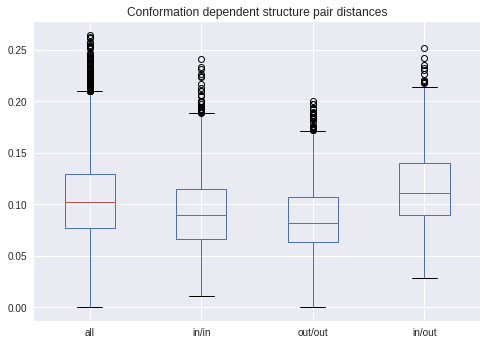

,all,in/in,out/out,in/out
count,28920.000000,8001.000000,2628.000000,9271.000000
mean,0.104406,0.091855,0.085887,0.114500
std,0.036447,0.032911,0.032152,0.032063
min,0.000000,0.011152,0.000000,0.028474
25%,0.076579,0.066259,0.063702,0.089615
50%,0.101820,0.089599,0.081348,0.110915
75%,0.129816,0.115203,0.106921,0.140108
max,0.263928,0.240757,0.200164,0.252040


In [13]:
for kinase, dfg in dfg_by_kinase.reset_index().groupby("kinase"):
    display(Markdown(f"#### {kinase}"))
    dfg = dfg.set_index("dfg")
    n_dfg_in = dfg.loc["in", "n_structures"]
    n_dfg_out = dfg.loc["out", "n_structures"]
    print(f"Number of DFG-in structures: {n_dfg_in}")
    print(f"Number of DFG-out structures: {n_dfg_out}")
    dfg_in_percentage = round(n_dfg_in / (n_dfg_in + n_dfg_out) * 100, 2)
    print(f"Percentage of DFG-in: {dfg_in_percentage}%")
    structure_distances_by_kinase = structure_distances[
        (structure_distances["kinase.1"] == kinase) & (structure_distances["kinase.2"] == kinase)
    ].reset_index(drop=True)
    plot_structure_distances_by_dfg_conformation_pairs(structure_distances_by_kinase)

<div class="alert alert-block alert-info">

We compare here only fingerprint distances for pairs of structures that describe the same kinase. We observe two interesting shifts:
    
1. The distribution for out/out pairs is overall lower than for in/in pairs. Potential explanations: definitions for DFG-out are stricter than for DFG-in; "real" diversity of DFG-out structures could be still unknown due to the lower number of structures for DFG-out than for DFG-in. 
2. The distribution of different DFG conformations (in/out) is overall higher than for equal DFG conformations (in/in and out/out). The fingerprint can discriminate DFG conformations of the same kinase.

</div>